# CycleGAN - Horse2Zebra

---

In this notebook will learn about Generative Adversarial Networks by implementing a Cycle GAN to transfer styles from Horse to Zebra.

**Important:** Set the Cloab environment to run on GPU

Author: Ramon Planas

Based on SIMPLE GAN colab from: Albert Pumarola

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import os
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from PIL import Image
import numpy as np
import math

## Utils
Some utils with minor importance

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

## Dataset
Download and prepare dataset


In [3]:
# Download horse2zebra
!mkdir -p ./datasets
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O ./datasets/horse2zebra.zip

# Unzip dataset
!unzip ./datasets/horse2zebra.zip -d ./datasets/

for details.

--2020-03-04 10:20:41--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  20.6MB/s    in 6.4s    

2020-03-04 10:20:48 (17.5 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/h

**Generate Dataset class**

In [0]:
class Horse2ZebraDataset(Dataset):
  """
  Dataset class to load images
  """
  def __init__(self, root_dir, transform=None):
    """
    Args:
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
        on a sample.
    """
    self.root_dir = root_dir
    self.transform = transform
    self.list_images = os.listdir(self.root_dir)

  def __len__(self):
    return len(self.list_images)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir, self.list_images[idx])
    image = Image.open(img_name)

    if self.transform:
      image = self.transform(image)

    return image

class TwoDatasets(Dataset):
  """
  Dataset class to get samples from two different image collections
  """
  def __init__(self, root_dirA, root_dirB, transform= None):
    self.root_dirA=root_dirA
    self.root_dirB=root_dirB
    self.filelistA = os.listdir(self.root_dirA)
    self.filelistB = os.listdir(self.root_dirB)
    self.transform=transform

  def __len__(self):
    return min(len(self.filelistA),len(self.filelistB))

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_nameA = os.path.join(self.root_dirA, self.filelistA[idx])
    img_nameB = os.path.join(self.root_dirB, self.filelistB[idx])

    imageA = Image.open(img_nameA).convert('RGB')
    imageB = Image.open(img_nameB).convert('RGB')

    if self.transform:
      imageA = self.transform(imageA)
      imageB = self.transform(imageB)

    return imageA, imageB


In [0]:
tf = transforms.Compose(
    [transforms.Resize(256, interpolation=0),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )

#horse2zebra_trainA = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/trainA', transform=tf)
#horse2zebra_testA  = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/testA', transform=tf)

#horse2zebra_trainB = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/trainB', transform=tf)
#horse2zebra_testB  = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/testB', transform=tf)

horse2zebra_train = TwoDatasets(root_dirA='./datasets/horse2zebra/trainA',root_dirB='./datasets/horse2zebra/trainB', transform=tf)
horse2zebra_test  = TwoDatasets(root_dirA='./datasets/horse2zebra/testA', root_dirB='./datasets/horse2zebra/testB',  transform=tf)

## Data Loader
Create data loaders for the horse2zebra dataset

In [0]:
batch_size = 10
#data_loader_trainA = torch.utils.data.DataLoader(horse2zebra_trainA, batch_size=batch_size, shuffle=True)
#data_loader_testA  = torch.utils.data.DataLoader(horse2zebra_testA,  batch_size=batch_size, shuffle=True)
#data_loader_trainB = torch.utils.data.DataLoader(horse2zebra_trainB, batch_size=batch_size, shuffle=True)
#data_loader_testB  = torch.utils.data.DataLoader(horse2zebra_testB,  batch_size=batch_size, shuffle=True)

data_loader_train = torch.utils.data.DataLoader(horse2zebra_train, batch_size=batch_size, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(horse2zebra_test,  batch_size=batch_size, shuffle=True)


Show some examples

1067
120


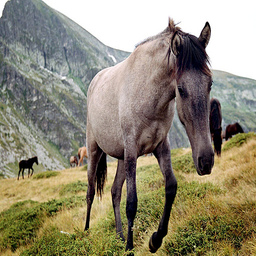

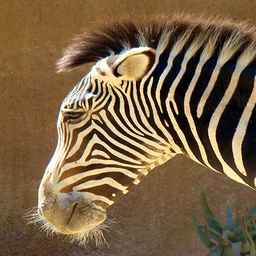

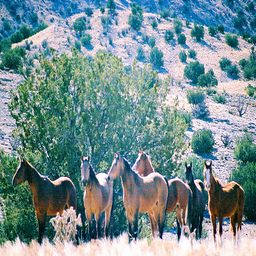

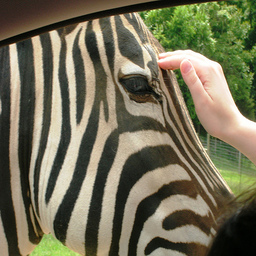

In [59]:
print(len(horse2zebra_train))
print(len(horse2zebra_test))

display_batch_images(horse2zebra_train[0][0])
display_batch_images(horse2zebra_train[0][1])
#
display_batch_images(horse2zebra_test[0][0])
display_batch_images(horse2zebra_test[0][1])

## Networks
First, lets define our simple generator

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # ENCODING
        self._enc_conv1 = self.conv_block(in_ch=3,   out_ch=64,  kern=7, stride=1, padding=0)
        self._enc_conv2 = self.conv_block(in_ch=64,  out_ch=128, kern=3, stride=2, padding=0)
        self._enc_conv3 = self.conv_block(in_ch=128, out_ch=256, kern=3, stride=2, padding=0)

        # TRANSFORMATION (RESNET)
        self._trans_block1 = nn.Sequential(
            self.conv_block(in_ch=256, out_ch=256, kern=3, stride=1, padding=1),
            self.conv_block(in_ch=256, out_ch=256, kern=3, stride=1, padding=1)
        )
        self._trans_block2 = nn.Sequential(
            self.conv_block(in_ch=256, out_ch=256, kern=3, stride=1, padding=1),
            self.conv_block(in_ch=256, out_ch=256, kern=3, stride=1, padding=1)
        )
        self._trans_block3 = nn.Sequential(
            self.conv_block(in_ch=256, out_ch=256, kern=3, stride=1, padding=1),
            self.conv_block(in_ch=256, out_ch=256, kern=3, stride=1, padding=1)
        )

        # DECODING
        self._dec_conv1 = self.deconv_block(in_ch=256, out_ch=128, kern=3, stride=2, padding=0)
        self._dec_conv2 = self.deconv_block(in_ch=128, out_ch=64,  kern=3, stride=2, padding=0)
        self._dec_conv3 = self.conv_block(in_ch=64, out_ch=3, kern=7, stride=1, padding=0)

    def conv_block(self, in_ch, out_ch, kern, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kern, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def deconv_block(self, in_ch, out_ch, kern, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kern, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encode -> Transform -> Decode
        # Encoding
        x = self._enc_conv1(x)
        x = self._enc_conv2(x)
        x = self._enc_conv3(x)

        # Transformation: Resnet blocks
        y = self._trans_block1(x)
        x += y
        y = self._trans_block2(x)
        x += y
        y = self._trans_block3(x)
        x += y

        # Decoding
        x = self._dec_conv1(x)
        x = self._dec_conv2(x)
        x = self._dec_conv3(x)
        
        return x

Similarly lets define a simple discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        return self._fc(x.view(-1, 512*4*4))

## Model
Now lets create the core of our task, the model.  Remember Cycle GANs loss:
$\mathcal{L}_{GAN}(G,D_Y,X,Y)=\mathbb{E}_{y\sim p_{data}(y)}\big[logD_Y(y)\big] + \mathbb{E}_{x\sim p_{data}(x)}\big[log(1-D_Y(G(x)))\big]$

$\mathcal{L}_{cyc}(G,F)=\mathbb{E}_{x\sim p_{data}(x)}\big[||F(G(x))-x||_1\big] + \mathbb{E}_{y\sim p_{data}(y)}\big[||G(F(y))-y||_1\big]$

The full objective is:

$\mathcal{L}(G,F,D_X,D_Y)=\mathcal{L}_{GAN}(G,D_Y,X,Y) + \mathcal{L}_{GAN}(F,D_X,Y,X) + \lambda\mathcal{L}_{cyc}(G,F)$

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generatorA2B = Generator()
        self._generatorB2A = Generator()
        self._discriminatorA = Discriminator()
        self._discriminatorB = Discriminator()

        # init weights
        self._generatorA2B.apply(init_weights)
        self._generatorB2A.apply(init_weights)
        self._discriminatorA.apply(init_weights)
        self._discriminatorB.apply(init_weights)

        # move to cuda
        self._generatorA2B.cuda()
        self._generatorB2A.cuda()
        self._discriminatorA.cuda()
        self._discriminatorB.cuda()
        
    def _create_optimizer(self):
        # generate optimizer
        self._optim = torch.optim.Adam(
            [
              {'params': self._generatorA2B.parameters(),   'lr': 0.0002, 'betas': (0.5, 0.999)},
              {'params': self._generatorB2A.parameters(),  ' lr': 0.0002, 'betas': (0.5, 0.999)},
              {'params': self._discriminatorA.parameters(), 'lr': 0.0002, 'betas': (0.5, 0.999)},
              {'params': self._discriminatorB.parameters(), 'lr': 0.0002, 'betas': (0.5, 0.999)}             
            ])
        
    def _init_criterion(self, batch_size):
        self._criterionGAN = nn.BCELoss()
        self._criterionCYC = nn.L1Loss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samplesA, real_samplesB):

        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)

        # optimize generator A2B
        loss_g = self._step_opt_g(fake_samplesA)
        
        # optimize discriminator A
        loss_dA = self._step_opt_d(real_samplesA, fake_samplesA.detach())
        
        return loss_gA2B, loss_gB2A, loss_dA, loss_dB, loss_cyc
      
    def _step_opt_g(self, fake_samples):

        # Reset gradients
        self._opt_g.zero_grad()
        
        # Calculate generator loss
        estim_fake = self._discriminator(fake_samples)
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples):
        # Reset gradients
        self._opt_d.zero_grad()

        # Calculate discriminator loss for real samples
        estim_real = self._discriminatorA(real_samples)
        loss_real = self._criterion(estim_real, self._label_real)

        # Calculate discriminator loss for fake samples
        estim_fake = self._discriminatorB(fake_samples)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item()
        
  

## Train

In [0]:
num_epochs = 1
model = Model(batch_size)

In [83]:
for epoch in range(num_epochs):
  
    # Train epoch A->B
    for n_batch, (real_samplesA, real_samplesB) in enumerate(data_loader_train):

        # Prepare batch data
        real_samplesA = Variable(real_samplesA).cuda()
        real_samplesB = Variable(real_samplesB).cuda()
          
        # Update model weights
        loss_gA2B, loss_gB2A, loss_dA, loss_dB, loss_cyc = model.step_optimization(real_samplesA, real_samplesB)
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, GA2B_loss: {loss_gA2B}, GB2A_loss: {loss_gB2A}")
            print(f"                             DA_loss: {loss_dA}, DB_loss: {loss_dB}, CYC_loss: {loss_cyc}")    
          
        # Show fake samples
        #if (n_batch) % 100 == 0:
        #    display_batch_images(real_samples)


NameError: ignored